# Semantic Search with Pinecone

In this project you'll explore the world of vector databases and their use as the underlying data storage infrastructure for AI.

The project will introduce you to one of the most popular vector databases in industry, Pinecone. You'll  

- Learn when and how semantic search can be used in products.
- Learn why semantic search often performs better than traditional keyword search.
- Learn how semantic search works, by exploring text about bees.
- Use semantic search on the Stanford Question Answering Dataset to answer questions about Beyoncé, Chopin, and other culture.



### Terminology

A _vector database_ is a type of database that only stores numeric vectors (unlike SQL databases that can store many different data types). By focusing on just one data format, vector databases can work quickly on 100s of billions of records.

_Embedding_ is the process of converting data types like text to a _vector format_ suitable for storage in a vector database.

_Vector search_ is when you find records in a vector database that are the best match to a query.

_Semantic_ means the meaning of words.

_Semantic search_ is when you do vector search on the meaning of text.

### Uses of vector search

Vector search is an incredibly important technology that we all use _every single day_.

Vector search is how Amazon knows what you want to buy before even you do, it's how Netflix recommends TV shows and films, and it's how Google serves the most relevant results from the web at search time. 

When searching using natural language (as in the Google example), semantic search can often perform much better than keyword matching  (which is how traditional search works).

![no-expansion](no-expansion.png)

*Note, orangutans are apes, not monkeys — but not every query will be perfect from users.*

In this example, a traditional search that relies on keyword / term overlap will not perform well—despite the fact that this document is very relevant to the query. Here we need to search based on _meaning_, not keywords. It is in these natural language queries—ie queries structured in the way we, as human beings, think—that we are able to retrieve the relevant document to our query.

Use-cases for this type of search are broad, but a few of the most common we find for semantic search include:

* **Document search**: a favorite use-case for organizations, particularly those with poor internal document discovery. Enabling their staff to find the information they need quicker is a huge optimization for many organizations.
* **Chatbot knowledge training**: another very popular use-case with the rise of AI chatbots is the ability to augment chatbots or **L**arge **L**anguage **M**odels (LLMs) with external data. We use semantic search to retrieval this data—this process is commonly referred to as **R**etrieval **A**ugmented **G**eneration (RAG).
* **Language classification**: by placing many classified sequences into a vector DB we are able to more quickly classify new sentences by simply comparing their semantic similarity to existing entries in the vector DB.
* **Agent/chatbot safety**: an increasingly popular use-case for semantic search is to use it in chatbot safety—it functions similarily to language classification but instead focuses on identifying malicious or unwanted inputs / outputs between users and chatbots.

These are a few example use-cases of semantic search, there are many more out there in the world which you will undoubtable encounter and be ready to recognize after completing this chapter and gaining the skills and knowledge to build your own semantic search apps.

## Before you begin

You'll need to get an [OpenAI API key](https://platform.openai.com/account/api-keys) and [Pinecone API key](https://app.pinecone.io). You can refer to *getting-started.ipynb* for steps on how to store these API keys in Workspace.

## Task 0: Setup

Before we start building our chatbot, we need to install some Python libraries. Here's a brief overview of what each library does:

* **openai**: This is the official OpenAI Python client. We'll use it to interact with the OpenAI API and generate embeddings for Pinecone.
* **datasets**: This library provides a vast array of datasets for machine learning. We'll use it to load our knowledge base for the chatbot.
* **pinecone-client**: This is the official Pinecone Python client. We'll use it to interact with the Pinecone vector DB where we will store our semantic search database.
You can install these libraries using pip like so:

In [1]:
!pip install -qU \
    openai==0.28.1 \
    datasets==2.14.5 \
    pinecone-client==2.2.4

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awswrangler 2.16.1 requires pyarrow<7.1.0,>=2.0.0, but you have pyarrow 13.0.0 which is incompatible.


## Task 1: Semantic Similarity

We will start by understand what is actually happening under the hood of Pinecone. As mentioned, we're doing something called "semantic similarity". Semantic similarity is simply comparing the semantic meaning of two chunks of text.

For example, let's define a list of sentences and compare them based on their "meaning" as we (as humans) understand them.

### Instructions

Run this code to define a list containing text data. 

In [2]:
sentences = [
    "the hive of bees protect their queen",                         # 0
    "a beehive is an enclosed structure in which honey bees live",  # 1
    "a condominium is an enclosed structure in which people live",  # 2
    "the flying stinging insects guard the matriarch"               # 3
]

### How similar are these sentences to humans?

It's clear to people that sentences 0 and 3 mean the same thing. Depending on the context we could view 1 and 2 as being similar in talking about where X lives, and 0, 1, and 3 are likewise similar in that they're talking about bees.

### How similar are these sentences using keyword matching?

If we were to compare these using the more traditional approach of keyword matching we would very quickly run into problems. The sentences 1 and 2 might score well, but the other sentences have little-to-no overlap in keywords—so they would not be identified as similar.

### Let's see how semantic search performs!

It is for these scenarios that we rely on semantic search. It works by teaching a language model to transform text into meaningful _vector embeddings_. We call them _meaningful_ because the language model actually learns to transform semantically similar sentences into a similar vector space (ie, in vector space, the embeddings are nearby).

We can try creating these embeddings using OpenAI's Ada 002 model like so:

### Instructions

Embed the sentences using the Ada AI.

- Import the OpenAI package.
- Set the model to Ada version 002. Assign to `model`.
- Send `sentences` to OpenAI API to create embeddings. Assign to `res`.
- Pull out the embeddings from the API response into list. Assign to `embeds`.

In [3]:
import openai

model = "text-embedding-ada-002"

res = openai.Embedding.create(input=sentences, engine=model)

In [5]:
embeds = [r["embedding"] for r in res["data"]]
len(embeds)

4

In [6]:
len(embeds[0])

1536

We have `4` embeddings (one for each of our four sentences). Ada 002 also outputs an embedding dimensionality of `1536`. 

That is, embedding has converted each sentence (regardless of its length) to a vector of 1536 floating point numbers.

In [7]:
len(embeds[0]), len(embeds[1]), len(embeds[2]), len(embeds[3])

(1536, 1536, 1536, 1536)

### Measuring similarity

Now that we have numeric vectors instead of text, we can calculate how similar the sentences are to each other. There are several common measures for calculating how similar two numeric vectors are, including _dot product_ and _cosine similarity_.

Here, we'll use the _dot product_. If you imagine the numeric vectors as arrows pointing in different directions in space, then the dot product measures how closely those arrows point in the same direction.

For each pair of sentences, you get a score between `-1` and `1`. A score of one mean that the sentences have identical meaning. Lower scores indicate less similarity, and in practice, for two well-formed sentences in English, the dot product similarity seldom drops much below `0.7`.

### Instructions

Calculate the dot product of the embedded sentences.

- From `numpy`, import `dot` and `array`.
- Convert `embeds` to an array. Assign to `embeds_arr`.
- Get the dot product of `embeds_arr` and its transpose. Assign to `dot_product`.
- Print the result.

In [8]:
from numpy import dot, array

embeds_arr = array(embeds)
embeds_arr.shape

(4, 1536)

In [9]:
dot_prod = dot(embeds_arr, embeds_arr.T)
dot_prod.shape

(4, 4)

In [10]:
dot_prod

array([[0.99999985, 0.88158122, 0.75926065, 0.89168835],
       [0.88158122, 1.00000007, 0.84662771, 0.81013042],
       [0.75926065, 0.84662771, 0.99999997, 0.74049849],
       [0.89168835, 0.81013042, 0.74049849, 0.99999991]])

### Visualizing similarity

Array of numbers are tedious to read, but can visualize these similarity values with a heatmap. For each value in the dot product, we get a colored cell.

Every sentence will be perfectly similar to itself, so the cells on the diagonal will have a score of one (and in the deafult Seabron color scheme have a pale red color).

Sentences that are less alike will have a lower score and a darker colored cell.

### Instructions

Draw a heatmap of the dot product array to visualize how similar each sentence is.

- Import `seaborn` with the alias `sns`.
- Draw a heatmap of `dot_product` with annotations.

<AxesSubplot: >

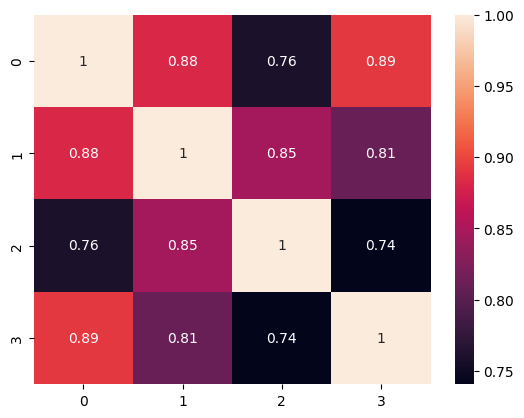

In [11]:
import seaborn as sns

sns.heatmap(dot_prod, annot=True)

### How similar are the sentences?

From this we can see that the most similar pairs are:

| Pair | Similarity | A | B |
| ---- | ---------- | --- | --- |
| 0-3  | 0.89       | "the hive of bees protect their queen" | "the flying stinging insects guard the matriarch" |
| 0-1  | 0.88       | "the hive of bees protect their queen" | "a beehive is an enclosed structure in which honey bees live" |
| 1-2  | 0.85       | "a beehive is an enclosed structure in which honey bees live" | "a condominium is an enclosed structure in which people live" |
| 1-3  | 0.81       | "a beehive is an enclosed structure in which honey bees live" | "the flying stinging insects guard the matriarch" |
| 0-2  | 0.76       | "the hive of bees protect their queen" | "a condominium is an enclosed structure in which people live" |
| 2-3  | 0.74       | "a condominium is an enclosed structure in which people live" | "the flying stinging insects guard the matriarch" |

This ordering of semantic similarity seems to align well with how most people would order them in terms of similarity in meaning—and it is for that, that these embedding models are optimized.

## Task 2: Importing the Dataset

We typically would not do semantic search for comparing just four sentences. Instead, it is done with thousands, millions, or even billions of records—Google is a great example of a partly semantic search done at large scales.

We'll perform semantic serach on the **S**tanford **Qu**estion **A**nswering **D**ataset v2 (SQuAD v2), the second version of a popular question-answering dataset. It contains _contexts_ which are simply paragraphs that contain information that can help a language model answer the question provided in the _question_ column.

In this task, you will:

* Download the [`squad_v2`](https://huggingface.co/datasets/squad_v2) dataset using Hugging Face Datasets.
* Take a look at the dataset structure, paying attention to the **context** and **question** columns.
* Deduplicate the **context** column to return a list of paragraphs that we will later search through.

### Instructions

Download and print the `squad_v2` dataset.

- From `datasets`, import `load_dataset`
- Load the `squad_v2` dataset, just getting the training split. Assign to `data`.
- Print the dataset object.

In [13]:
from datasets import load_dataset

data = load_dataset("squad_v2", split="train")
data

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 130319
})

### Instructions

Print and read some records from the squad dataset.

- Print several records of `data`, one at at time.
- *Read the contents. What is the structure of each record? What are the contents about?*

In [14]:
data[0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

In [16]:
data[1]

{'id': '56be85543aeaaa14008c9065',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'What areas did Beyonce compete in when she was growing up?',
 'answers': {'text': ['singing and dancing'], 'answer_start': [207]}}

In [18]:
data[500]

{'id': '56bfc281a10cfb14005512b6',
 'title': 'Beyoncé',
 'context': 'Beyoncé has received praise for her stage presence and voice during live performances. Jarett Wieselman of the New York Post placed her at number one on her list of the Five Best Singer/Dancers. According to Barbara Ellen of The Guardian Beyoncé is the most in-charge female artist she\'s seen onstage, while Alice Jones of The Independent wrote she "takes her role as entertainer so seriously she\'s almost too good." The ex-President of Def Jam L.A. Reid has described Beyoncé as the greatest entertainer alive. Jim Farber of the Daily News and Stephanie Classen of Star Phoenix both praised her strong voice and her stage presence.',
 'question': 'Who chose her as number one on his list of Best singers/ Dancers?',
 'answers': {'text': ['Jarett Wieselman'], 'answer_start': [87]}}

In [19]:
data[1500]

{'id': '56cc5fd66d243a140015ef54',
 'title': 'Sino-Tibetan_relations_during_the_Ming_dynasty',
 'context': "As evident in his imperial edicts, the Hongwu Emperor was well aware of the Buddhist link between Tibet and China and wanted to foster it. Rolpe Dorje, 4th Karmapa Lama (1340–1383) rejected the Hongwu Emperor's invitation, although he did send some disciples as envoys to the court in Nanjing. The Hongwu Emperor also entrusted his guru Zongluo, one of many Buddhist monks at court, to head a religious mission into Tibet in 1378–1382 in order to obtain Buddhist texts.",
 'question': 'Who did Rolpe Dorje send as envoys to court in Nanjing?',
 'answers': {'text': ['disciples'], 'answer_start': [249]}}

As there are many questions for each context, we see plenty of duplication in the _context_ column. Our next task is to deduplicate those records to give us a deduped `contexts` list.

### Instructions

Remove duplicates of context values from the dataset.

- Deduplicate the `context` element of `data` by converting to a set and back to a list. Assign to `contexts`.
- Print the length of `contexts`.

In [20]:
contexts = list(set(data["context"]))

len(contexts)

19029

## Task 3: Creating a Vector Index



Storing the embeddings in a NumPy array is not very permanent, or useful for sharing with other people. The embeddings need to be stored in a vector database, in this case Pinecone.

This task involves some setup steps to get the embeddings into Pinecone.


### Terminology 

In Pinecone there are three levels of containers.

At the highest level is the _vector database_ itself. This is the equivalent to a SQL DB.

Within the SQL DB we have tables which contain our data; with Pinecone we have _vector indexes_.

One more layer that we can optionally use is _namespaces_. A namespace is a partition within a vector index. Every namespace is fully separated from other namespaces, and because of this they are often use to support multi-tenancy. So, if your product served multiple business, you could store business A's data in namespace "a", and business B's data in namespace "b" to ensure they are always separated.

We will not dive into namespaces here, but they are a useful concept to be aware of when building with Pinecone.

To create our first vector index we first need to initialize our connection to Pinecone.

### Instructions

Initialize Pinecone, getting setup details from Workspace environment variables.

- Import `os`.
- Import `pinecone`.
- Initialize pinecone, setting the API key and environment.

In [22]:
import os
import pinecone

api_key = os.environ["PINECONE_API_KEY"]
env = os.environ["PINECONE_ENVIRONMENT"]

pinecone.init(api_key=api_key, environment=env)

Now we can create our index. There are a few parameters we must include. Those are:

* `index_name`: this can be anything you want, it is simply the name of the index—so use something informative!
* `dimension`: this is the expected dimensionality of the vectors in the index. We saw earlier that Ada 002 encodes into 1536-dimensional vectors, so we use that same `1536` number here.
* `metric`: this is the similarity metric we will use to compare vectors. For Ada 002 we can use `dot_product` (as we did above) or `cosine`. Other embedding may require us to use `euclidean` but this is less common.

### Instructions

Create a vector index and connect to it.

- Import `time`.
- Give the index a meaningful name, such as `"squad-search"`. Assign to `index_name`.
- Check if the index already exists. (It shouldn't on the first run.)
    - If the index does not exist then create it.
    - Wait for the index to initialize. If the index status isn't "ready" then sleep for a couple of seconds.
- Connect to the index. Assign to `index`.
- View the index stats.

In [23]:
pinecone.list_indexes()

['rerankers']

In [24]:
import time

index_name = "squad-search"

if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        index_name,
        dimension=1536,
        metric="cosine"
    )
    while not pinecone.describe_index(index_name).status["ready"]:
        time.sleep(2)

In [25]:
index = pinecone.Index(index_name)

In [26]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

Our index has now been created and we can see that the vector count is currently `0`, as we haven't added anything to it yet.

## Task 4: Indexing our Data

Now that we have our embedding model (Ada 002), dataset, and vector index, we can begin embedding our data and added it all to the index.

We will do this in batches of `100` to avoid overloading the OpenAI or Pinecone APIs (or causing out of memory errors on our own system).

### Instructions

Split the dataset into batches and add it to the vector index.

- From `tqdm`, import `tqdm` (a progress bar).
- Set the batch size to 100. Assign to `batch_size`.
- Loop from 0 to the length of contexts by batch size, adding a progress bar.
    - Find the end of the batch. Assign to `i_end`.
    - Get the contexts for the batch to encode. Assign to `meta_batch`.
    - Get the IDs for the batch. Assign to `ids_batch`.
    - Get the contexts for the batch to encode. Assign to `context_batch`.
    - Create the embeddings for the batch contexts. Assign to `res`.
    - Pull out the embeddings for each record in the response data. Assign to `embeds`.
    - Add contexts to metadata for easy retrieval later. Assign to `metadata`.
    - Combine IDs, embeddings, and metadata as list of tuples. Assign to `to_upsert`.
    - Upsert to Pinecone.

In [28]:
from tqdm import tqdm

batch_size = 100

for i in tqdm(range(0, len(contexts), batch_size)):
    i_end = min(i+batch_size, len(contexts))
    
    context_batch = contexts[i:i_end]
    id_batch = [str(x) for x in range(i, i_end)]
    
    res = openai.Embedding.create(input=context_batch, engine=model)
    embeds = [r["embedding"] for r in res["data"]]
    
    metadata = [{"context": x} for x in context_batch]
    
    to_upsert = zip(id_batch, embeds, metadata)
    index.upsert(vectors=to_upsert)

100%|██████████| 191/191 [04:12<00:00,  1.32s/it]


Now we can check our index size and we should see it has been populated with records (as seen via the vector count):

### Instructions

Check on updates to the vector index now that it contains the squad dataset.

- View the index stats again.
- *What has changed since you last looked?*

In [29]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 19029}},
 'total_vector_count': 19029}

## Task 5: Semantic Search

We've now indexed our data, meaning we're ready for semantic search!

This just means that we start with a query, that is, a question to ask. Then by using similarity, we find the three questions in the squad dataset with the nearest meaning to the one we asked.

### What's the search workflow?

1. The query is text, so first it needs to be embedded. 
2. The embedded query can be searched using Pinecone's `index.query()`. To return the metadata in our response we'll also need to set `include_metadata=True`.

Let's create the query and embed it with Ada 002.

### Instructions

Think of a question, then embed it.

- Specify a question, `"What three composers did Chopin take inspiration from?"`. Assign to `query`.
- Create the embedding for the query. Assign to `res`.
- Pull out the query vector from the response. Assign to `xq`.

In [30]:
query = "What three composers did Chopin take inspiration from?"

res = openai.Embedding.create(input=[query], engine=model)

In [32]:
xq = res["data"][0]["embedding"]

In [33]:
len(xq)

1536

Now we query Pinecone.

### Instructions

Query Pinecone for matches to the embedded question.

- Query Pinecone for the top 3 matches to `xq`, including metadata. Assign to `res`.
- Print the results.

In [34]:
res = index.query(xq, top_k=3, include_metadata=True)
res

{'matches': [{'id': '3369',
              'metadata': {'context': 'Chopin was educated in the tradition of '
                                      'Beethoven, Haydn, Mozart and Clementi; '
                                      "he used Clementi's piano method with "
                                      'his own students. He was also '
                                      "influenced by Hummel's development of "
                                      'virtuoso, yet Mozartian, piano '
                                      'technique. He cited Bach and Mozart as '
                                      'the two most important composers in '
                                      "shaping his musical outlook. Chopin's "
                                      'early works are in the style of the '
                                      '"brilliant" keyboard pieces of his era '
                                      'as exemplified by the works of Ignaz '
                                      'M

That's a big response, let's clean it up and also wrap the search logic into a single `search` function.

### Instructions

- Run this code to define a convenience function for semantic search with prettier output.

In [35]:
def search(query):
    res = openai.Embedding.create(input=[query], engine=model)
    xq = res["data"][0]["embedding"]
    res = index.query(xq, top_k=3, include_metadata=True)
    # format
    xc = []
    for match in res["matches"]:
        context = match["metadata"]["context"]
        score = match["score"]
        xc.append(f"[{round(score, 2)}]: {context}")
    return xc

### Instructions

Print each result of searching for the query.

In [36]:
for result in search(query):
    print(result)

[0.89]: Chopin was educated in the tradition of Beethoven, Haydn, Mozart and Clementi; he used Clementi's piano method with his own students. He was also influenced by Hummel's development of virtuoso, yet Mozartian, piano technique. He cited Bach and Mozart as the two most important composers in shaping his musical outlook. Chopin's early works are in the style of the "brilliant" keyboard pieces of his era as exemplified by the works of Ignaz Moscheles, Friedrich Kalkbrenner, and others. Less direct in the earlier period are the influences of Polish folk music and of Italian opera. Much of what became his typical style of ornamentation (for example, his fioriture) is taken from singing. His melodic lines were increasingly reminiscent of the modes and features of the music of his native country, such as drones.
[0.88]: Polish composers of the following generation included virtuosi such as Moritz Moszkowski, but, in the opinion of J. Barrie Jones, his "one worthy successor" among his co

### So who did influence Chopin?

The top result directly answers the question of who influenced Chopin. It seems there are a lot of influences, depending on what aspect of his music and what time period of his work you consider. Beethoven, Haydn, Mozart, Clementi, Hummel, Bach, Moscheles, and Kalkbrenner are mentioned, as well as Polish folk music and Italian opera.

The second and third results talk about people who were influenced by Chopin. This is closely related in meaning to the question, but not quite what was asked.

## Summary

In this code-along, you've seen 

- some examples of when vector search and semantic search can be used.
- why semantic search can have better performance than keyword search.
- how to embed text with the Ada AI.
- how to initialize a Pinecone database and create a vector index.
- how to add text data to a Pinecone vector index.
- how to query a vector index to find close matches.

## Keep Going!

The squad dataset contains a lot of question and answer pairs, so there are many more things you can search for.

Repeat the steps in Task 5, trying different values for the query.

Here are a few ideas for the query:

* `"What years did Ogedei Khan rule?"`
* `"Which model of iPod combined the headphone jack and data port?"`
* `"Who resurrects Zelda after the fight with Ganondorf?"`

Make sure to look at the output from each search result, and see how well the results answer the query.